Повторяю препроцессинг отсюда [https://www.mdpi.com/1099-4300/19/9/488], denoising сигнала объяснен тут [https://sci-hub.se/10.1016/j.bspc.2013.01.005]

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import decimate
import pywt
import scipy

In [2]:
def load_record(record_name):
    path = os.path.join("../train/", record_name + ".npy")
    record = np.load(path)
    return record


In [3]:
record = load_record("00009_hr")
record.shape

(12, 5000)

The ECG signal downloaded from MIT-BIH database was sub-
jected to wavelet based denoising using Daubechies D6 (‘db6’)
wavelet basis function [19]. The ECG signals sampled at 360 Hz were
decomposed up to 9 levels using db6 wavelet. The 9th level approx-
imation sub band contains the frequency range of 0–0.351 Hz which
is mainly the baseline wander, was not used for reconstructing
the denoised signal. Also the ECG would not contain much infor-
mation after 45 Hz. Therefore the first and second level detail
coefficients consisting frequency band of 90–180 Hz and 45–90 Hz
respectively were not used for reconstructing the denoised ECG.
The required sub bands, the 3rd, 4th, 5th, 6th, 7th, 8th and 9th level
detail signals were only used (all other sub-band coefficients were
replaced with zeros) for computing the inverse wavelet transform
and the denoised ECG signal is obtained [19]. The required sub band
coefficients were kept and in the sub bands which are not required,
the coefficients were all replaced with zeros and the inverse DWT
is computed to obtain the denoised ECG.


daubechies(db) wavelet был выбран, потому что больше всего похож на сигнал экг

In [4]:
def denoise(record, noise_level):
    """
        record - оригинальный экг сигнал.
        noise_levels - до какого уровня wavelet decomposition включительно считать шумом.
    """
    db6 = pywt.Wavelet("db6")
    # имеет вид [cA_n, c_Dn, ... , C_D1], 
    # где cA_n - aproximation coefficients последнего уровня, они нам не нужны, cD_n - detail coefficients n уровня.
    coefs = pywt.wavedec(record, db6, axis=-1)
    # убираем aproximation coeficients
    coefs[0] = np.zeros_like(coefs[0])
    # обнуляем начальные левелы, так написано в статье про денойзинг, 
    # так как экг сигнал с частотой >45 hz имеет много шума.
    for i in range(1, noise_level+1):
        coefs[-i] = np.zeros_like(coefs[-i])
    denoised = pywt.waverec(coefs, db6)
    return denoised

In [5]:
def plot(signal):
    plt.figure(dpi=200)
    plt.figure(figsize=(20, 8))
    plt.plot(range(len(signal[0])), signal[0])  

2 уровень денойзинга показал лучшие результаты в обучении модели по сравнению с 3 и 4 уровнями.

<Figure size 1200x800 with 0 Axes>

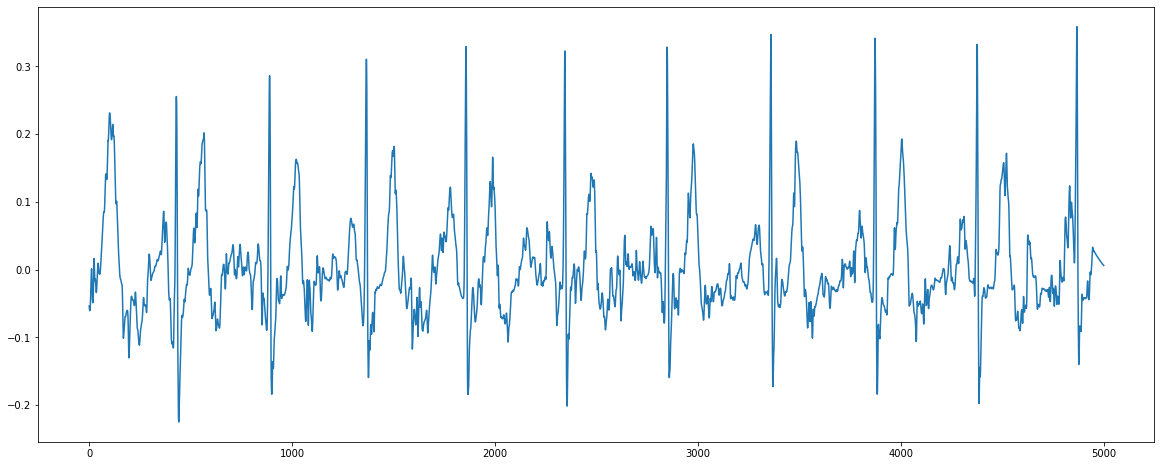

In [6]:
plot(denoise(record, 2))

<Figure size 1200x800 with 0 Axes>

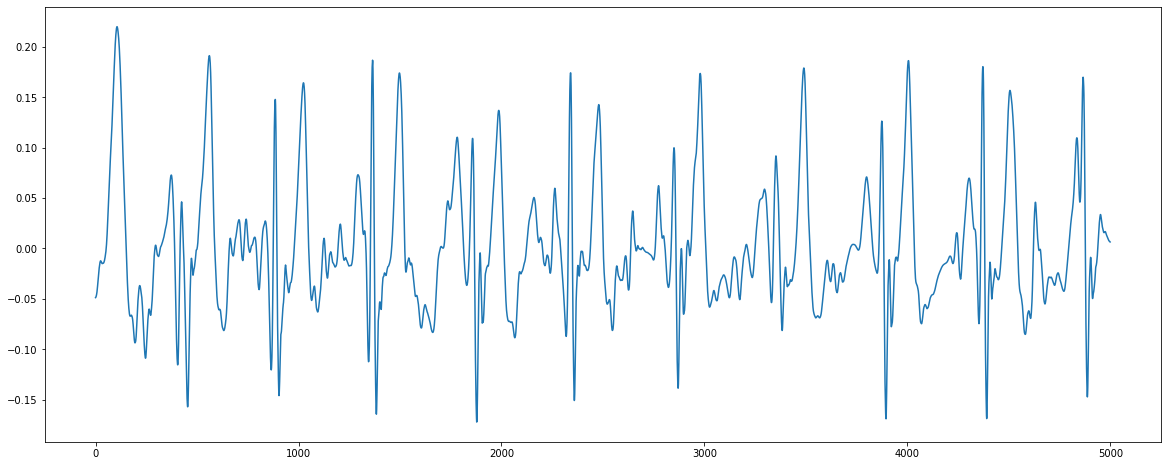

In [7]:
plot(denoise(record, 4))

Пример работы алгоритма Pan-Tompkins.

На графике звездочкой отмечены R-peaks каждого отдельного удара сердца.

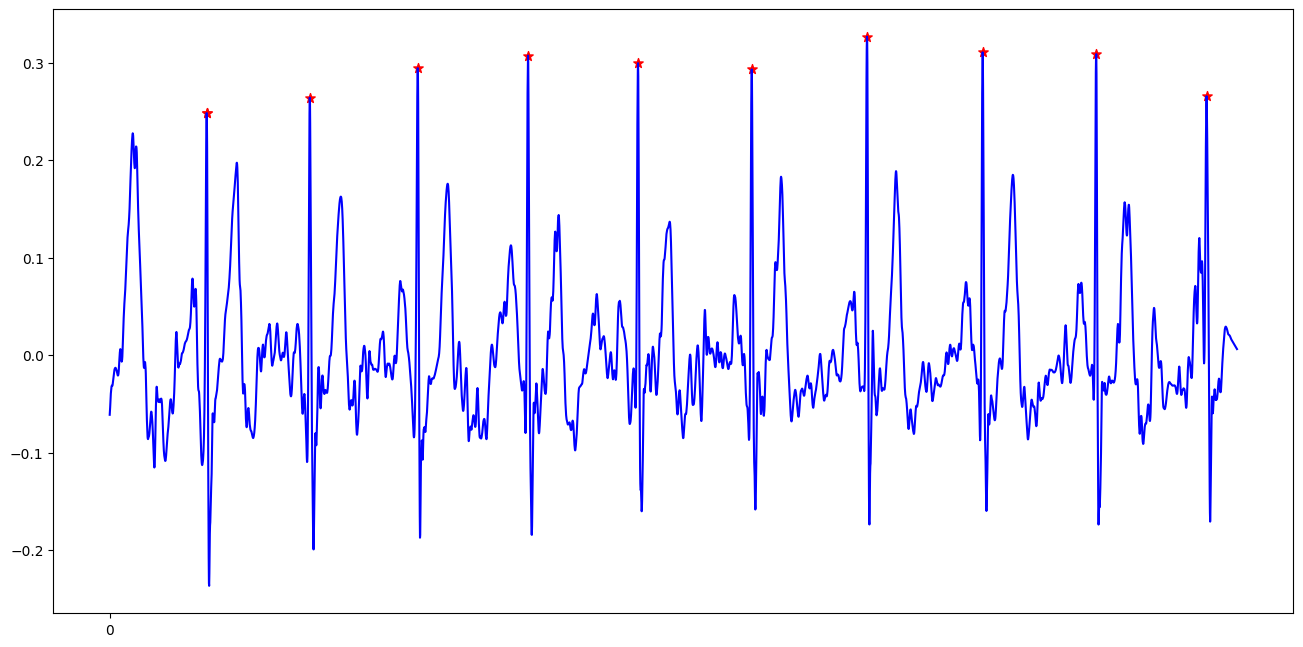

In [8]:
from pan_tompkins import extract_beats
results = extract_beats(denoise(record, 3), freq=500, n_seconds4beat=1, test=True)

Этот пайплайн сначала убирает шум при помощи сверху указанного алгоритма, потом выделяет отдельные удары сердца при помощи алгоритма Pan-Tompkins.

In [10]:
from preprocessing_with_beats import PipelineBeatExtraction

pipeline = PipelineBeatExtraction('./../train/', num_secs_for_beat=1, noise_level=1)
beats = pipeline.run_pipeline("00009_hr")
beats.shape


ModuleNotFoundError: No module named 'preprocessing_with_beats'

Примеры полученных ударов сердца из каждого лида ЭКГ сигнала.

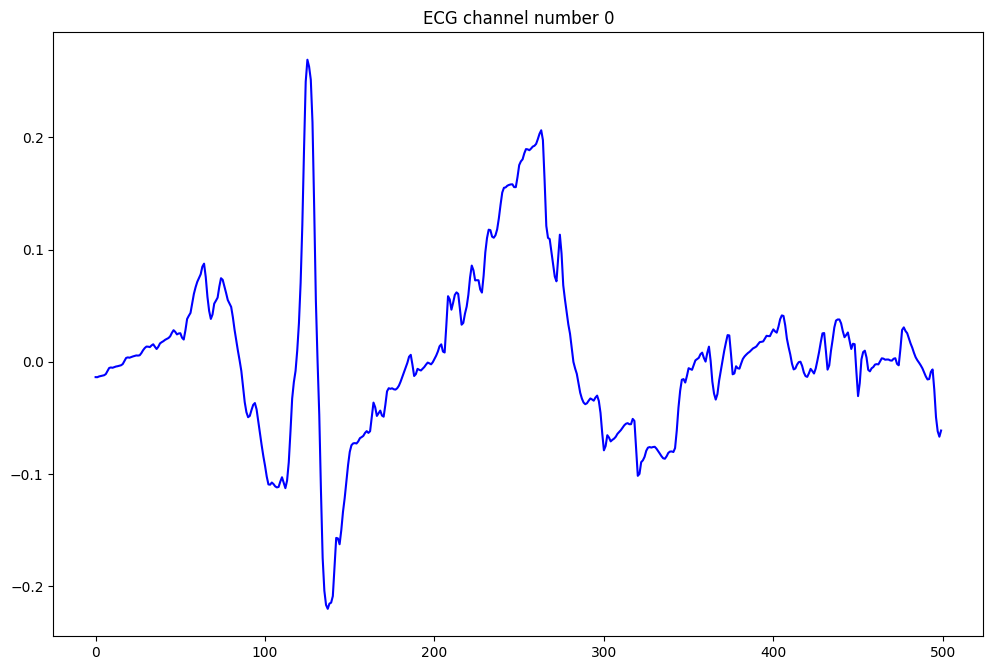

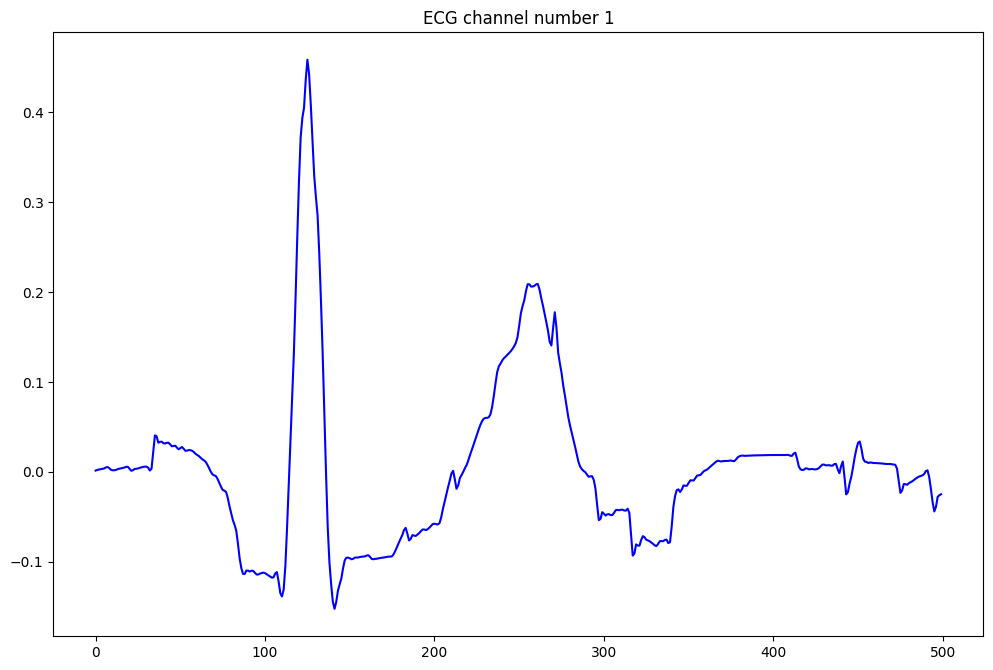

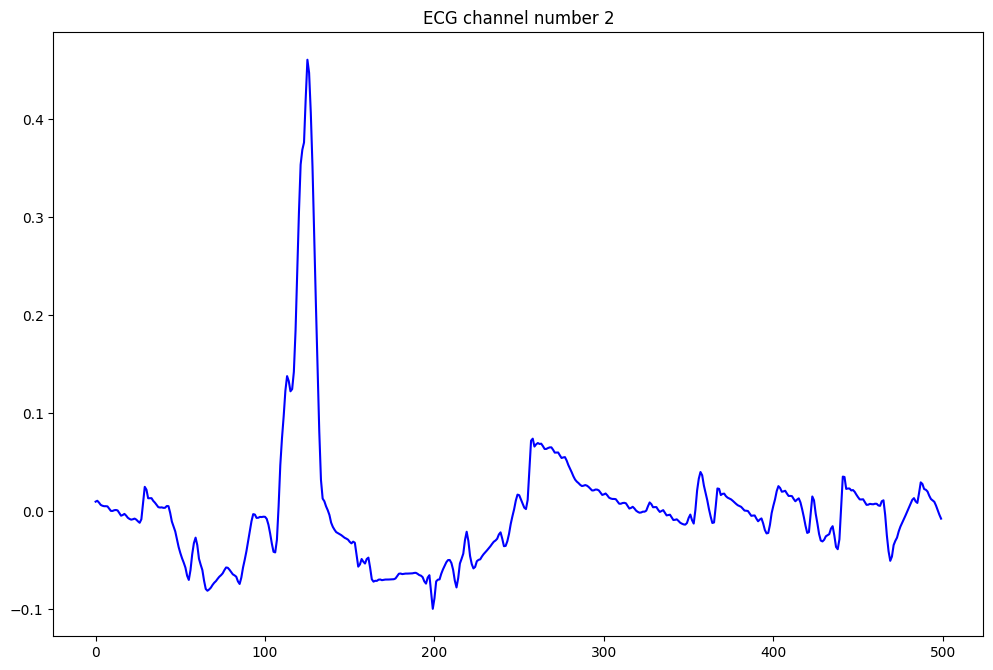

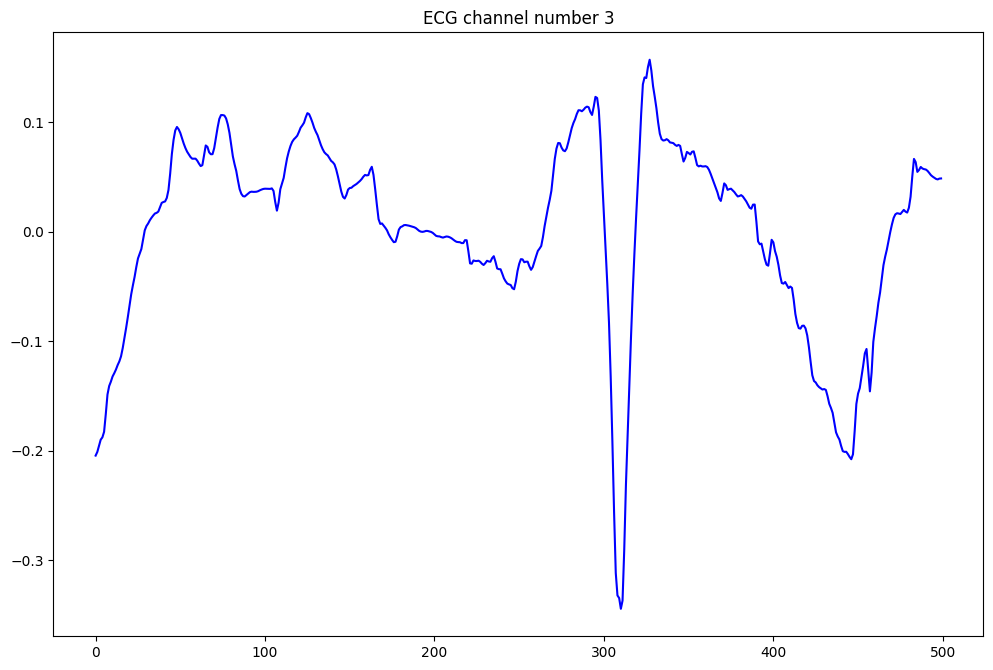

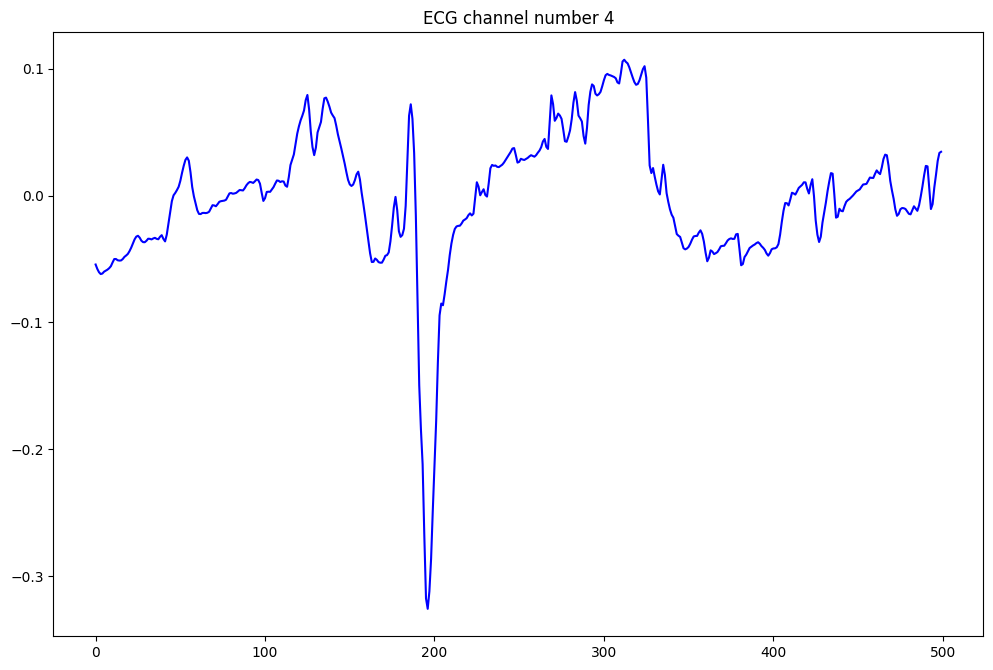

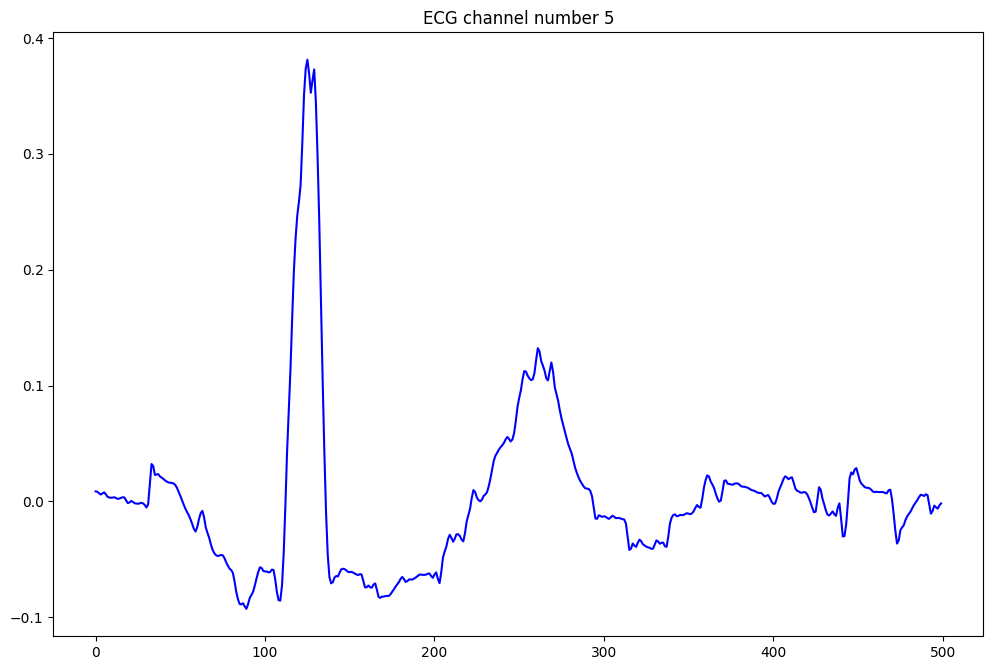

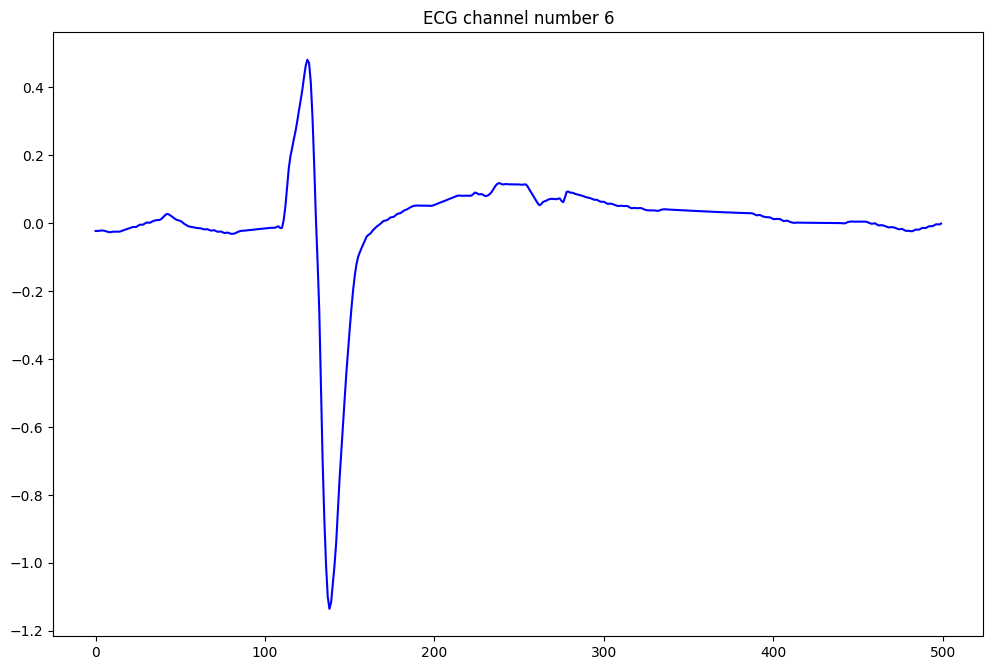

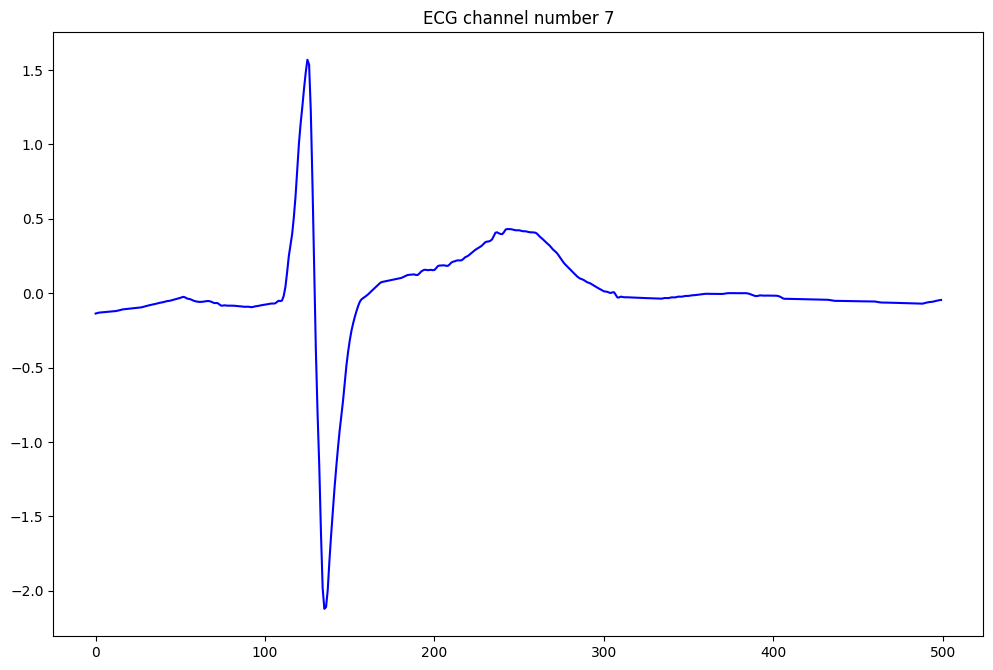

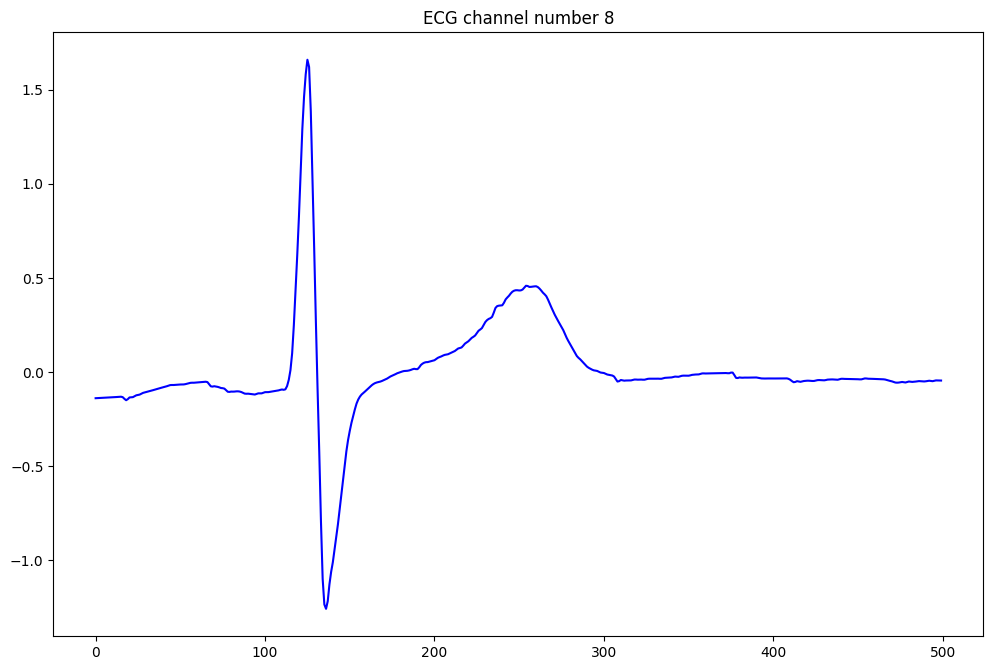

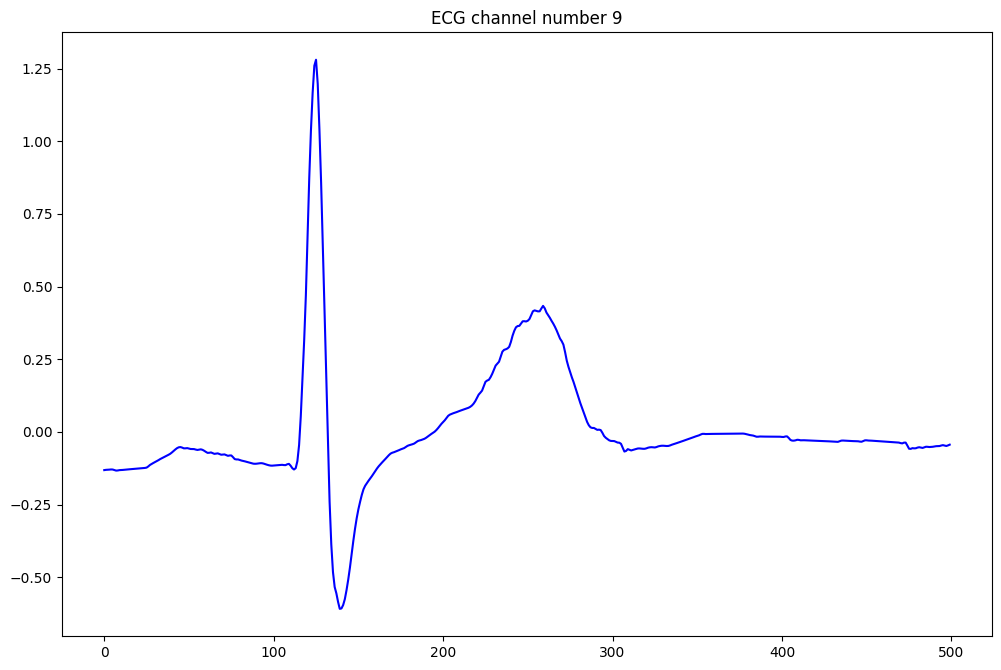

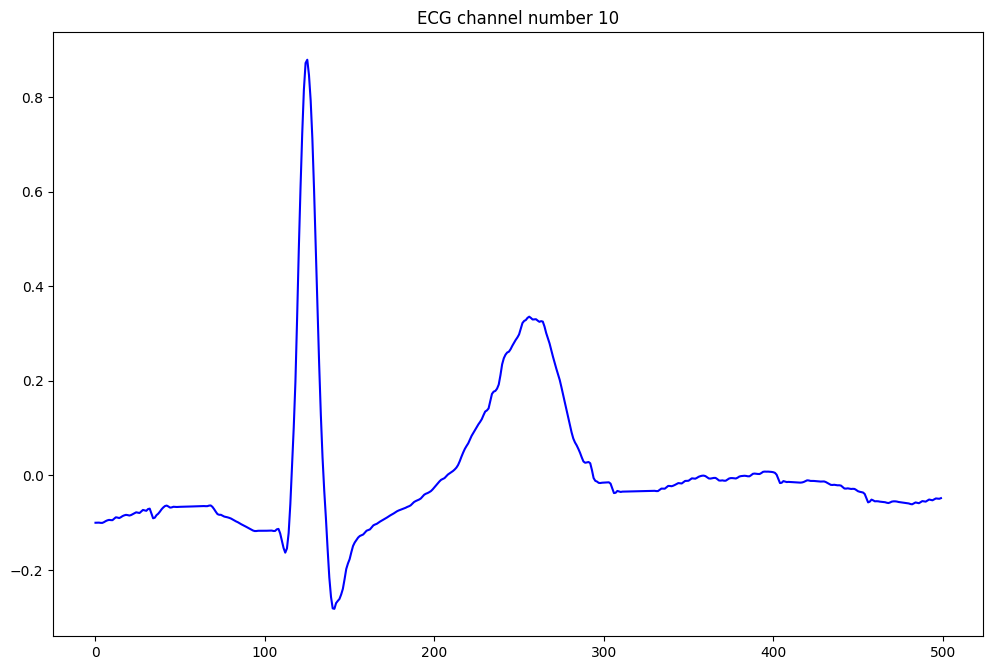

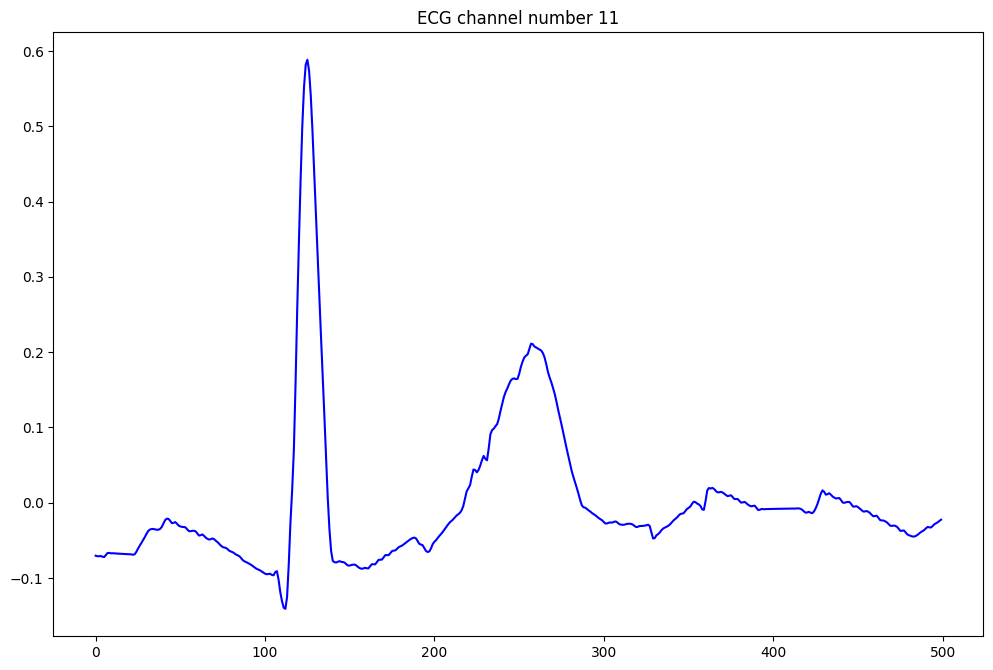

In [ ]:
for ecg_channel in range(12):
    for beat in beats[ecg_channel][:1]:
        plt.figure(figsize=(12, 8), dpi=100)
        plt.title(f"ECG channel number {ecg_channel}")
        plt.plot(beat, color='blue')
